In [1]:
!unzip /content/drive-download-20220416T184043Z-001.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import imblearn
import warnings
# warnings.filterwarnings('ignore')

In [2]:
def upsample_label(temp_x, temp_y):
    y_time_list = temp_y['time'].values
    y_label = temp_y['label'].values
    jdx = 0
    label_list = []
    for index,row in temp_x.iterrows():
        try:
            if row['time'] > y_time_list[jdx]:
                jdx+=1
            label_list.append(y_label[jdx])
        except:
            label_list.append(y_label[jdx - 1])
    return label_list

In [3]:
filepath = 'TrainingData/'
column_list = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','subject', 'time', 'label']
final_df = pd.DataFrame([], columns = column_list)
for i in glob.glob(filepath + '*.csv'):
    df_type = i.split('.')[0].split('__')[1]
    file_name = i.split("\\")[1].split("__")[0]
#     file_name = i.split('/')[1].split('__')[0]
    if df_type == 'x':
        x = open(filepath + file_name + '__x.csv')
        x = pd.read_csv(x)
        x['subject'] = [file_name] * x.shape[0]
        
        x_time = open(filepath + file_name + '__x_time.csv')
        x_time = pd.read_csv(x_time)
        x['time'] = x_time
        
        y = open(filepath + file_name + '__y.csv')
        y = pd.read_csv(y)
        y['subject'] = [file_name] * y.shape[0]
        
        y_time = open(filepath + file_name + '__y_time.csv')
        y_time = pd.read_csv(y_time)
        y['time'] = y_time
        
        y.columns = ['label', 'subject', 'time']
        label_list = upsample_label(x, y)
        x['label'] = label_list
        x.columns = column_list
        final_df = pd.concat([final_df, x], ignore_index=True)

In [4]:
final_df.shape
from scipy import stats

def create_windows(X, y, time_steps=1, step=1):
    Xs, ys = [], []
      
    for i in range(0, len(X) - time_steps + 1, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])

    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [5]:
X = final_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
y = final_df['label']

TIME_STEPS = 40  # Window Size
STEP = 1

X_data, y_data = create_windows(X, y, time_steps=TIME_STEPS,step=STEP)


In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

df_label = pd.DataFrame(y_data, columns=['label'])
df_label['index_'] = df_label.index

## Library for performing undersampling 
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
df_balanced, balanced_labels = rus.fit_resample(df_label, df_label['label'])

sos = SMOTE(sampling_strategy='not majority')
df_balanced, balanced_labels  = sos.fit_resample(df_balanced, balanced_labels)

df_balanced = pd.DataFrame(df_balanced, columns=['label', 'index_'])

X_data = X_data[df_balanced['index_'].values]
y_data = y_data[df_balanced['index_'].values]

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.1, random_state=42)

## Converting label to OneHot Encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

In [28]:
X_train = np.asarray(X_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional, Conv1D, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

input_shape = (X_train.shape[1], X_train.shape[2])
output_dim = 4
lr = 0.001

In [21]:
model=Sequential()

model.add(Conv1D(32, 3, activation='relu',padding = "same",input_shape=input_shape))
model.add(Dropout(0.2)) 
model.add(Conv1D(64, 3, activation='relu',padding = "same"))
model.add(Dropout(0.2)) 
# model.add(Conv1D(128, 3, activation='relu',padding = "same"))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.5)) 
model.add(LSTM(256,return_sequences=False))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(256, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(output_dim))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['acc'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 40, 32)            608       
                                                                 
 dropout_3 (Dropout)         (None, 40, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 40, 64)            6208      
                                                                 
 dropout_4 (Dropout)         (None, 40, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40, 256)           328704    
                                                                 
 dropout_5 (Dropout)         (None, 40, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)              

In [23]:
hist = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs=30,
    batch_size=64,
    shuffle=True
)

Epoch 1/30
2406/2406 [==============================] - 36s 14ms/step - loss: 0.3100 - acc: 0.8788 - val_loss: 0.1771 - val_acc: 0.9346
Epoch 2/30
2406/2406 [==============================] - 33s 14ms/step - loss: 0.1908 - acc: 0.9289 - val_loss: 0.1412 - val_acc: 0.9484
Epoch 3/30
2406/2406 [==============================] - 32s 13ms/step - loss: 0.1574 - acc: 0.9420 - val_loss: 0.1253 - val_acc: 0.9528
Epoch 4/30
2406/2406 [==============================] - 32s 13ms/step - loss: 0.1381 - acc: 0.9493 - val_loss: 0.1054 - val_acc: 0.9628
Epoch 5/30
2406/2406 [==============================] - 32s 13ms/step - loss: 0.1220 - acc: 0.9556 - val_loss: 0.1170 - val_acc: 0.9583
Epoch 6/30
2406/2406 [==============================] - 34s 14ms/step - loss: 0.1140 - acc: 0.9586 - val_loss: 0.0879 - val_acc: 0.9687
Epoch 7/30
2406/2406 [==============================] - 34s 14ms/step - loss: 0.1061 - acc: 0.9615 - val_loss: 0.0874 - val_acc: 0.9691
Epoch 8/30
2406/2406 [==========================

In [29]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1663
           1       0.99      1.00      1.00      1661
           2       0.99      1.00      0.99      1581
           3       0.96      0.97      0.96      1693

    accuracy                           0.98      6598
   macro avg       0.98      0.98      0.98      6598
weighted avg       0.98      0.98      0.98      6598



In [31]:
import matplotlib.pyplot as plt

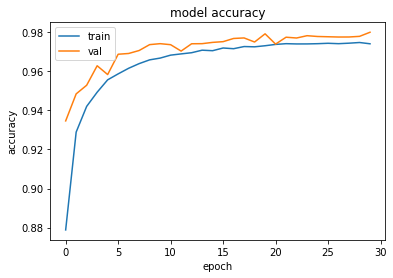

In [32]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

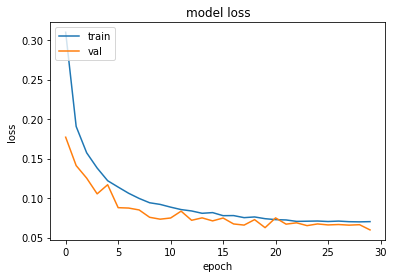

In [33]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
def create_test_windows(X, time_steps=1, step=1):
    Xs = []
    for i in range(0, len(X) - time_steps + 1, step):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [35]:
def test_windows(X, time_steps, step):
    Xs = []
    n_records = X.shape[0]
    remainder = (n_records - time_steps) % step
    num_windows = 1 + int((n_records - time_steps - remainder) / step)
    for k in range(num_windows):
        Xs.append(X[k*step:time_steps-1+k*step+1])
    return np.array(Xs)

In [36]:
filepath = 'TestData/'
column_list = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','subject', 'time']
columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
df_test_data = pd.DataFrame([], columns = column_list)

## Reading prediction file 
for idx in glob.glob(filepath + '*.csv'):
    df_type = idx.split('.')[0].split('__')[1]

    if df_type == 'x':
        subject_name = idx.split('.')[0].split('__')[0].split('/')[-1]
        x_path = idx.split('.')[0].split('__')[0] + '__' + df_type + '.csv'
        x_time_path = idx.split('.')[0].split('__')[0] + '__' + 'x_time' + '.csv'
        y_time_path = idx.split('.')[0].split('__')[0] + '__' + 'y_time' + '.csv'
        df_x = pd.read_csv(x_path, names=column_list[:6])

        print("Original number of values: ", df_x.shape)
        ## Converting windows for test data 
        sampled_test = create_test_windows(df_x[columns],TIME_STEPS, STEP)
        print("Number of windows: ", len(sampled_test))

        ## Making inference on test data 
        pred_test = model.predict(sampled_test)
        pred_test = np.argmax(pred_test, axis=1)
        pred_test = list(pred_test)
        pred_test = np.asarray(pred_test)
        pred_test = np.concatenate([pred_test, np.asarray([pred_test[-1]]*120)])
        pred_test = pd.DataFrame(pred_test, columns=['label'])

        ## Sampling the prediction to match the test set sampling frequency. 
        df_mode = pred_test['label'].rolling(window=4, min_periods=1).apply(lambda x: int(stats.mode(x)[0]))[::4]

        y_time = pd.read_csv(y_time_path, header=None).shape[0]
        print(y_time, len(df_mode.values))

        pred_df = pd.DataFrame(df_mode.values)
        pred_df = pred_df.astype('int64', copy=False)
        pred_df.to_csv(subject_name + '__y.csv', index=False, columns=None)

Original number of values:  (37991, 6)
Number of windows:  37952
9498 9518
Original number of values:  (49081, 6)
Number of windows:  49042
12270 12291
Original number of values:  (51761, 6)
Number of windows:  51722
12940 12961
Original number of values:  (45319, 6)
Number of windows:  45280
11330 11350
